In [5]:
# download data

import tarfile
import os
from subprocess import call


data_zip = 'BSR_bsds500.tgz'
data_dirc = "data"
if not os.path.isdir(data_dirc):
    print("data file not found.")
    print("checking if zip file exists")
    if not os.path.exists(data_zip):
        print("zip file does not exist.")
        print("downloading data...")
        url = "http://web.archive.org/web/20120508113820if_/http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
        filename = wget.download(url)
        print("download " + filename)
        print("data downloaded")
    else:
        print("Zip file exists")

    print("extracting data")
    tar = tarfile.open(data_zip, "r")
    tar.extractall()
    
    if not os.path.isdir(data_dirc):
        os.makedirs(data_dirc)
    
    os.popen('cp -r BSR/BSDS500/data/images/* data').read()
    os.popen('cp -r BSR/BSDS500/data/groundTruth data/').read()
    os.remove('data/train/Thumbs.db')

else:
    print("data found")


    
import sys


def progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    s = str(count) + "/" + str(total)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s ...%s\r' % (bar, s, status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)




data found


In [6]:
import scipy.io
dirc_truth = os.path.join(data_dirc, 'groundTruth')

def show_image_groundTrue(image_path):
    
    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.01)
    n = 2
    m = 4
    j = 1
    img = imread(os.path.join(data_dirc, image_path))
    fig.add_subplot(n, m, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img)
    
    image_path = image_path.replace('jpg', 'mat')
    mat = scipy.io.loadmat(os.path.join(dirc_truth, image_path))
    
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][1]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    j = j + 1
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][0]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    plt.show()
show_image_groundTrue(os.path.join('train', pyramid_image))


NameError: name 'pyramid_image' is not defined

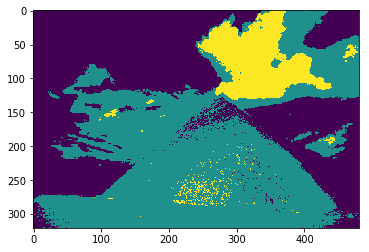

In [41]:
# kmeans

from sklearn.cluster import KMeans

def kmeans_cluster(img, n_clusters):
    
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    
    img = img.reshape(n * m, colors) # n * m rows each with a vector of RGB
    kmeans = KMeans(n_clusters=n_clusters, precompute_distances=True,n_jobs=-1).fit(img)
    
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
#     for i in range(0, n * m):
#         img[i] = centers[labels[i]]
    
    labels = labels.reshape(n, m)
    return labels


    
img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = kmeans_cluster(img, 3)
plt.imshow(result)
plt.show()
# print(result)







In [9]:
import numpy as np
import imageio

def kmeans_images(original_path, result_path, segs):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    
    images = os.listdir(original_path)
    n = len(images)
    i = 1
    for image in images:
        progress_bar(i, n, image)
        i = i + 1
        
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            dirc = os.path.join(result_path, str(seg))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
                
            c = np.copy(img)
            result = kmeans_cluster(c, seg)
            np.save(os.path.join(dirc, image), result)
        
    print("kmeans done")

n_tirals = 1
for i in range(1, n_tirals + 1):
    print("run number: " + str(i))
    f = "run_" + str(i)
    kmeans_images(dirc_train, os.path.join(dirc_kmeans, f), [3,5,7,9,11])








run number: 1


NameError: name 'dirc_train' is not defined

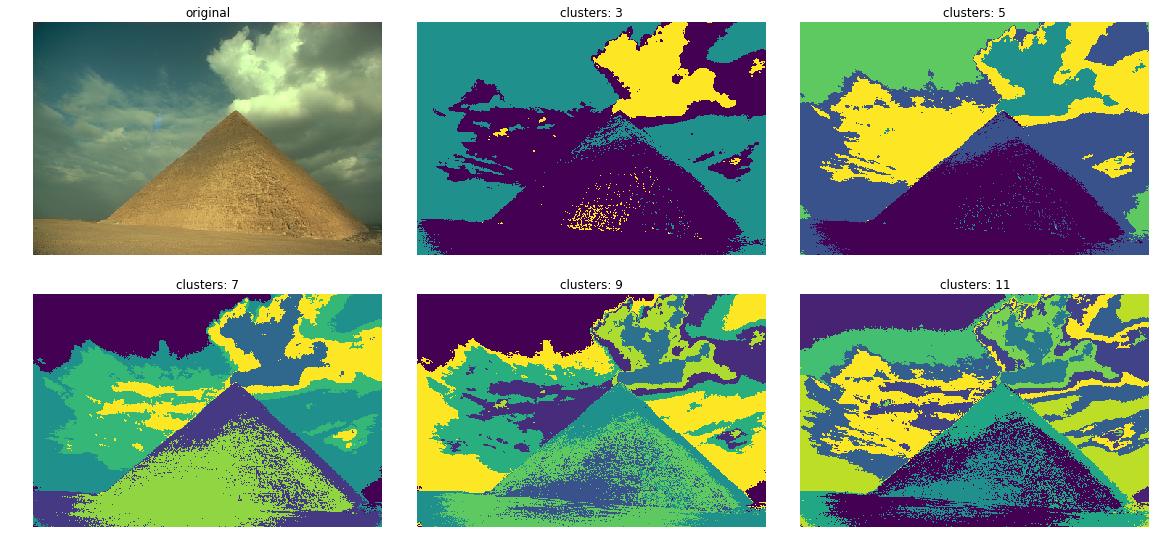

In [19]:
# display image and it's segmentation
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

def visualize(image_name, original_path, segmentation_path, segs):

    img = imread(os.path.join(original_path, image_name))

    
    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    
    l = len(segs) + 1
    n = 2
    m = l // n
    
    fig.add_subplot(n, m, 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img)
    
    i = 2
    for f in segs:
        img = np.load(os.path.join(segmentation_path, f, image_name + ".npy"))
        fig.add_subplot(n, m, i)
        plt.axis('off')
        plt.title('clusters: ' + f)
        plt.imshow(img)
        
        i = i + 1
        
#     plot(img)
    plt.show()

dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")
pyramid_image = "299091.jpg"
segs = ["3", "5", "7", "9", "11"]
visualize(pyramid_image, dirc_train, os.path.join(dirc_kmeans, "run_1"), ["3", "5", "7", "9", "11"])





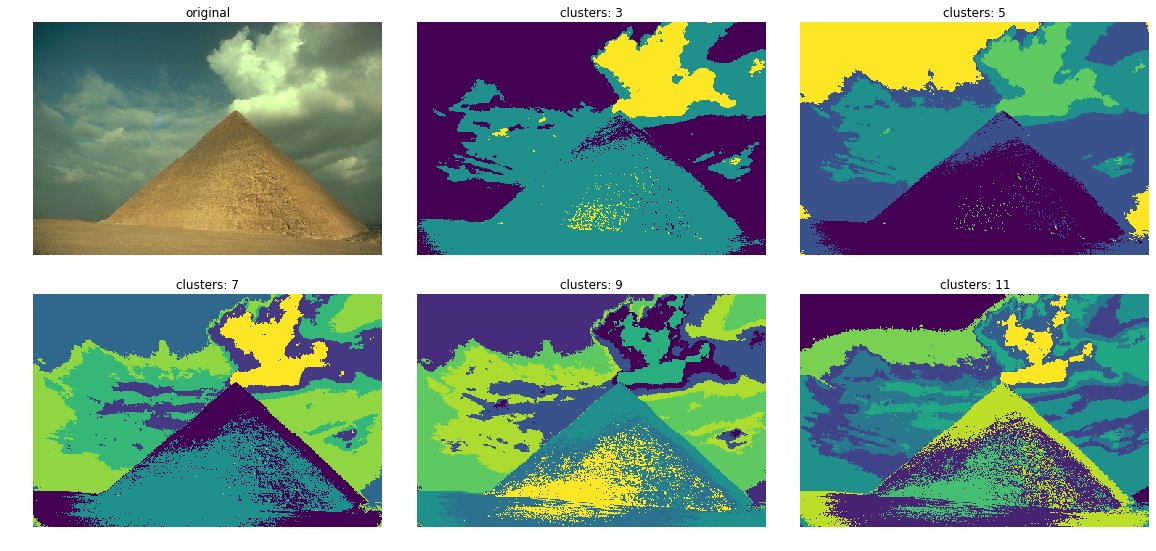

In [45]:
visualize(pyramid_image, dirc_train, os.path.join(dirc_kmeans, "run_1"), ["3", "5", "7", "9", "11"])

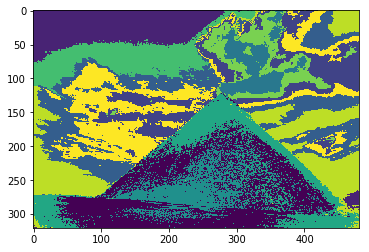

0.38065229850733523


In [23]:
# F-measure


def cluster_freq(clusters, truth):
    freq = {}
    g = {}
    for c, t in zip(clusters, truth):
        if not c in freq:
            freq[c] = {}
        
        if not t in freq[c]:
            freq[c][t] = 0
        
        freq[c][t] = freq[c][t] + 1
        
        if not t in g:
            g[t] = 0
        g[t] = g[t] + 1
        
    return (freq, g)


# clusters and truth are two dimention arrays
def f_measure(clusters, truth):
    
    (n, m) = clusters.shape
    (nn, mm) = truth.shape
    clusters = clusters.reshape(n * m)
    truth = truth.reshape(nn * mm)
    # map of cluster id (from clusters) to a map of cluster id (from truth)
    # and it's frequency
    (freq, g) = cluster_freq(clusters, truth)
    
    f_score = 0
    n = 0
    for k, v in freq.items(): # for each cluster
        total = 0
        max_index = -1
        max_count = -1
        
        for a, f in v.items():
            total = total + f
            if(f > max_count):
                max_count = f
                max_index = a
                
        prec = max_count * 1.0 / total
        rec = max_count / g[max_index]
        
        f = 2.0 * (prec * rec) / (prec + rec)
        f_score = f_score + f
        
        n = n + 1
        
    f_score = f_score / n
    
    return f_score
    
img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))


assert f_measure(img, img) == 1

plt.imshow(img)
plt.show()

f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
print(f)





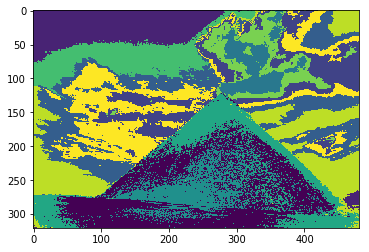

0.030043658433960403


In [24]:
#  Conditional Entropy

# clusters and truth are two dimention arrays
import math
def conditional_entropy(clusters, truth):

    (n, m) = clusters.shape
    size = n * m * 1.0
    (nn, mm) = truth.shape
    
    clusters = clusters.reshape(n * m)
    truth = truth.reshape(nn * mm)
    
    (freq, g) = cluster_freq(clusters, truth)
    
    ht = 0
    
    for k, v in freq.items():
        t = 0.0 # total elements in cluster
        for a, b in v.items():
            t = t + b
        
        x = 0
        for a, b in v.items():
    
            l = - b / t * math.log(b / t)
            x = x + l
        
        ht = x * t / size
    
    return ht
    

img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

assert conditional_entropy(img, img) == 0


plt.imshow(img)
plt.show()

f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
print(f)





In [51]:
# image metrics

def image_metrics(original_path, result_path, image_name, segs):
    
    ground_truth = os.path.join(data_dirc, 'groundTruth', original_path, image_name.replace('jpg', 'mat'))
    mat = scipy.io.loadmat(ground_truth)
    
    gt = []
    gt.append(mat['groundTruth'][0][0][0][0][0])
    gt.append(mat['groundTruth'][0][1][0][0][0])
    gt.append(mat['groundTruth'][0][2][0][0][0])
    
    result = {}
    
    for seg in segs:
        img = np.load(os.path.join(result_path, seg, image_name + ".npy"))
        r = {'f_measure' : {'best':0, 'worst': 1, 'average':0},
             'entropy':{'best':0, 'worst': 1, 'average':0}}
    
        i = 1
        for g in gt:
            k = "groundTruth_" + str(i)
            i = i + 1
            
            f1 = f_measure(img, g)
            r['f_measure'][k] = f1
            r['f_measure']['best'] = max(r['f_measure']['best'], f1)
            r['f_measure']['worst'] = min(r['f_measure']['worst'], f1)
            r['f_measure']['average'] = r['f_measure']['average'] + f1
            
            f2 =  conditional_entropy(img, g)
            r['entropy'][k] = f2
            r['entropy']['best'] = max(r['entropy']['best'], f2)
            r['entropy']['worst'] = min(r['entropy']['worst'], f2)
            r['entropy']['average'] = r['entropy']['average'] + f2
            
        r['f_measure']['average'] = r['f_measure']['average'] / 3  
        r['entropy']['average'] = r['entropy']['average'] / 3
            
        result[seg] = r
        
    return result
    

metrics = image_metrics("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)
print(metrics)
    
    

{'3': {'f_measure': {'best': 0.49899083209885503, 'worst': 0.3913984895359001, 'average': 0.43880922303108055, 'groundTruth_1': 0.3913984895359001, 'groundTruth_2': 0.49899083209885503, 'groundTruth_3': 0.4260383474584865}, 'entropy': {'best': 0.023296088365113935, 'worst': 0.022588779525240976, 'average': 0.022873444461347883, 'groundTruth_1': 0.022735465493688746, 'groundTruth_2': 0.022588779525240976, 'groundTruth_3': 0.023296088365113935}}, '5': {'f_measure': {'best': 0.6029146357887785, 'worst': 0.4509771621131361, 'average': 0.5021055044534734, 'groundTruth_1': 0.6029146357887785, 'groundTruth_2': 0.4524247154585054, 'groundTruth_3': 0.4509771621131361}, 'entropy': {'best': 0.16747605414850864, 'worst': 0.16390178725692647, 'average': 0.16568789338063616, 'groundTruth_1': 0.16568583873647338, 'groundTruth_2': 0.16390178725692647, 'groundTruth_3': 0.16747605414850864}}, '7': {'f_measure': {'best': 0.5075348544140754, 'worst': 0.39180920127424507, 'average': 0.431001985753475, 'gro

In [53]:

# from prettytable import PrettyTable
    
# x = PrettyTable()

# x.field_names = ["City name", "Area", "Population", "Annual Rainfall"]

# x.add_row(["Adelaide", 1295, 1158259, 600.5])
# x.add_row(["Brisbane", 5905, 1857594, 1146.4])
# x.add_row(["Darwin", 112, 120900, 1714.7])
# x.add_row(["Hobart", 1357, 205556, 619.5])
# x.add_row(["Sydney", 2058, 4336374, 1214.8])
# x.add_row(["Melbourne", 1566, 3806092, 646.9])
# x.add_row(["Perth", 5386, 1554769, 869.4])

# print(x)
from IPython.display import HTML, display
import tabulate

def image_metrics_report(original_path, result_path, image_name, segs):

    report = image_metrics(original_path, result_path, image_name, segs)
#     print(report)
    
    rd = 5
    
    for seg in segs:
        d = report[seg]

        table = [["clusters: " + seg, "groundTruth_1","groundTruth_2", "groundTruth_3",
                 "best", "worst", "average"],
             ["f_measure"],
             ["entropy"]]

        for i in range(1, len(table[0])):
            table[1].append(round(d["f_measure"][table[0][i]], rd))

        for i in range(1, len(table[0])):
            table[2].append(round(d["entropy"][table[0][i]], rd))

        display(HTML(tabulate.tabulate(table, tablefmt='html')))

    

  
    
image_metrics_report("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)




# table = [["Sun",696000,1989100000],
#          ["Earth",6371,5973.6],
#          ["Moon",1737,73.5],
#          ["Mars",3390,641.85]]
# display(HTML(tabulate.tabulate(table, tablefmt='html')))






clusters: 3,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.3914,0.49899,0.42604,0.49899,0.3914,0.43881
entropy,0.02274,0.02259,0.0233,0.0233,0.02259,0.02287


clusters: 5,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.60291,0.45242,0.45098,0.60291,0.45098,0.50211
entropy,0.16569,0.1639,0.16748,0.16748,0.1639,0.16569


clusters: 7,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.50753,0.39366,0.39181,0.50753,0.39181,0.431
entropy,0.12089,0.11896,0.12147,0.12147,0.11896,0.12044


clusters: 9,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.4211,0.33119,0.32961,0.4211,0.32961,0.36064
entropy,0.03546,0.03383,0.03616,0.03616,0.03383,0.03515


clusters: 11,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.38054,0.2779,0.27699,0.38054,0.27699,0.31181
entropy,0.03168,0.03009,0.03247,0.03247,0.03009,0.03141


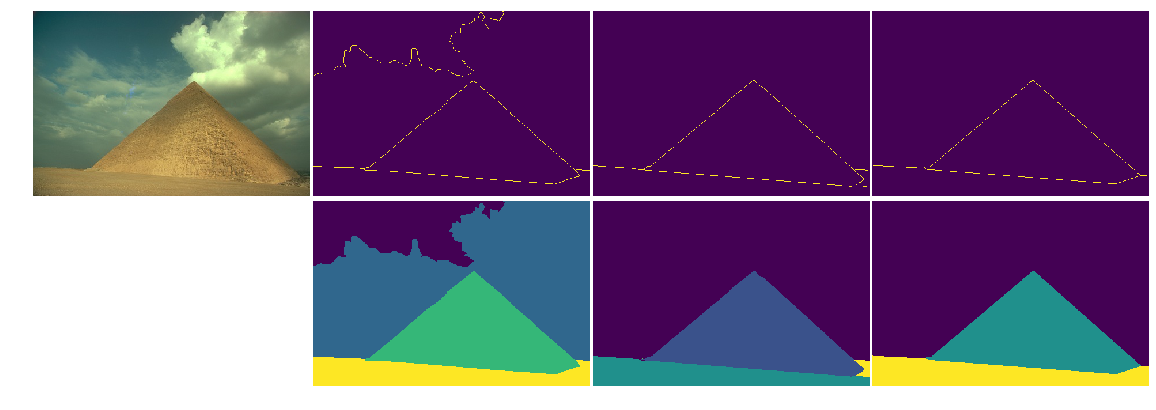

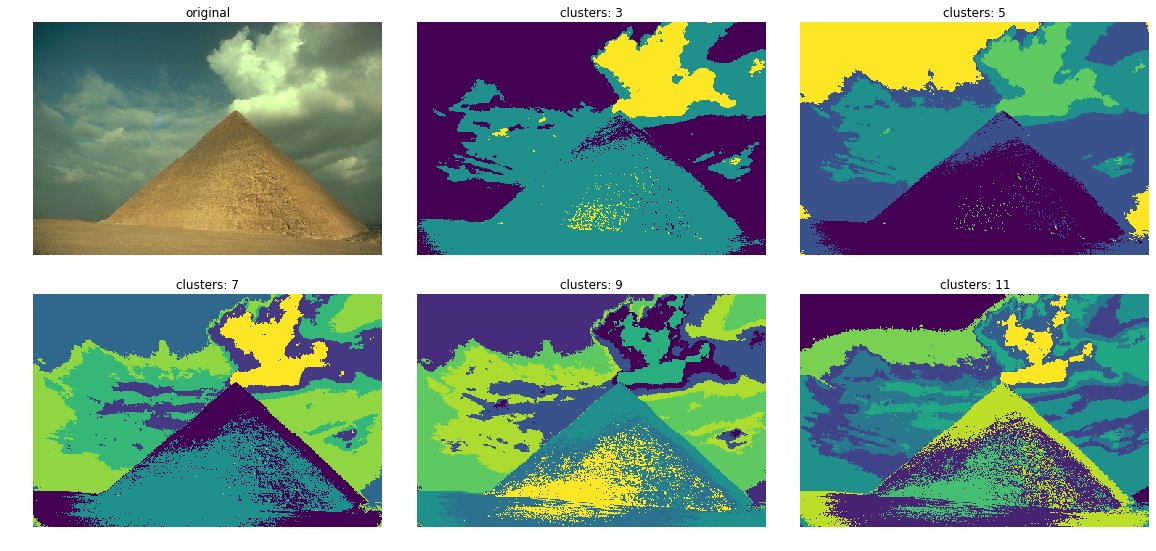

clusters: 3,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.3914,0.49899,0.42604,0.49899,0.3914,0.43881
entropy,0.02274,0.02259,0.0233,0.0233,0.02259,0.02287


clusters: 5,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.60291,0.45242,0.45098,0.60291,0.45098,0.50211
entropy,0.16569,0.1639,0.16748,0.16748,0.1639,0.16569


clusters: 7,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.50753,0.39366,0.39181,0.50753,0.39181,0.431
entropy,0.12089,0.11896,0.12147,0.12147,0.11896,0.12044


clusters: 9,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.4211,0.33119,0.32961,0.4211,0.32961,0.36064
entropy,0.03546,0.03383,0.03616,0.03616,0.03383,0.03515


clusters: 11,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.38054,0.2779,0.27699,0.38054,0.27699,0.31181
entropy,0.03168,0.03009,0.03247,0.03247,0.03009,0.03141


In [54]:


def image_report(original_path, result_path, image_name, segs):
    
    show_image_groundTrue(os.path.join(original_path, image_name))

    visualize(image_name, os.path.join(data_dirc,original_path),
             result_path, segs)
    
    image_metrics_report(original_path, result_path, image_name, segs)
    
    
image_report("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)
    

**Normalized Cut** 
- Normalized cut is also known by spectral clustering.
- Here n the spectral_cluster method, it performs the spectral clustering with certain paramaters:
 - n_clusters: the number of clusters.
 - tpe: the type of spectral clustering either rbf or nearest_neighbor
- At the begining the size of the image is changed because it consumes alot of memory space if it is represented in its original size.
- The method SpectralClustering() in sklearn is used in spectral clustering.
- The SpectralClustering() methos accepts only 2d wrapped images images so the image will be reshapped.  

In [8]:
from sklearn.cluster import SpectralClustering
from skimage.transform import resize

def spectral_cluster(img, n_clusters, tpe, gamma=1):
    img = resize(img, (40, 60), anti_aliasing=True)
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    img = img.reshape(n * m, colors) 
    spectral = SpectralClustering(n_clusters=n_clusters,
                       gamma=gamma, affinity=tpe, 
                       n_neighbors=n_clusters,
                       n_jobs=-1).fit(img)    
    labels = spectral.labels_
    labels = labels.reshape(n, m)
    return labels

    
img = imread(os.path.join(dirc_train, "100075.jpg"))
img.flags.writeable = True
result = spectral_cluster(img, 11, 'nearest_neighbors', 1)
plt.imshow(result)
plt.show()
print(result)

NameError: name 'imread' is not defined

**Two ways for normalized cut**
- The two ways for the normalized cut is:
 - rbf with gamma values [1, 10].
 - Nearest neighbor method.
- Here in this method, all the images in the data set is processed using spectral clustering.
- Here the normalized cut is tested with rbf and nearest neighbor with 3 5 7 9 11 clusters.
- Tt is  tested with two values for gamma 1 and 10.
- The images with gamma = 10 is more sharmer and obvious than gamma = 1.

In [11]:
def normalized_cut_images(original_path, result_path, segs, tpe, gamma):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    images = os.listdir(original_path)
    n = len(images)
    i = 1
    for image in images:
        progress_bar(i, n, image)
        i = i + 1
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            dirc = os.path.join(result_path, str(seg) + "_" + str(gamma))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
            c = np.copy(img)
            result = spectral_cluster(c, seg, tpe, gamma)
            np.save(os.path.join(dirc, image), result)
    print("normalized_cut_done with " + tpe)
    
dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn")
# normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_nn, "run_1"), [3,5,7,9,11], 'nearest_neighbors', 1)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 10)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)

NameError: name 'dirc_train' is not defined

**Comparison**
- A comparison between the resultant image from rbf with gamma 1 and 10 and nearset neighbor is run.
- The number of clusters used = 11.
- The most sharper and obvious is rbf with gamma = 10
- Then rbf with gamma = 1.
- Then nearest neighbor.

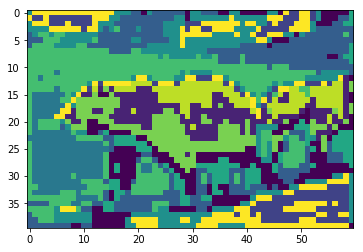

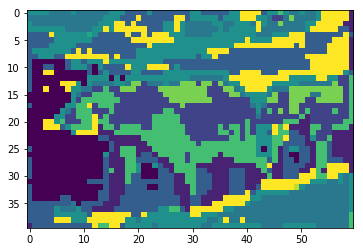

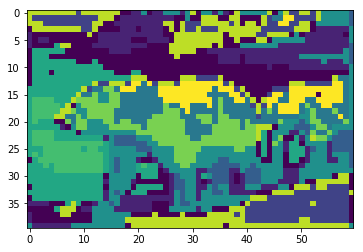

In [18]:
image = '100075.jpg'
img1 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_10", image + ".npy"))
img2 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
img3 = np.load(os.path.join(dirc_normalized_nn , "run_1", "11_1", image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

**Measuring the conditional entropy**
- As the conditional entropy decrease, this means that there is a better image.
- The conditional entropy is calculated for rbf 10 and nearest neighbor.
- The conditional entropy is nearly similar between them.

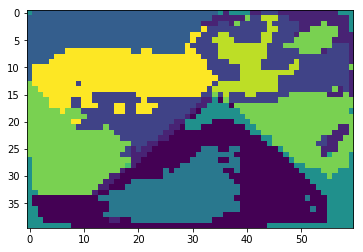

rbf entropy
0.011856560935668885
0.09598301149946566
0.07967685614089919
0.050293060898635084
0.061131615806826085
0.08877512353711263
0.12314187499895381
0.0031938633692893603
nn entropy
0.011856560935668885
0.09598301149946566
0.07967685614089919
0.050293060898635084
0.061131615806826085
0.08877512353711263
0.12314187499895381
0.0031938633692893603


In [25]:
img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

def entropy(path, sub):
    images = os.listdir(dirc_train)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))
        f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(f)
print("rbf entropy")
entropy(dirc_normalized_rbf, '11_10')
print("nn entropy")
entropy(dirc_normalized_nn, '11_1')

**Measuring the f-measure**
- As the f-measure increases, this means that there is a better image.
- The f-measure is calculated for rbf 10 and nearest neighbor.
- The f-measure is nearly similar between them.

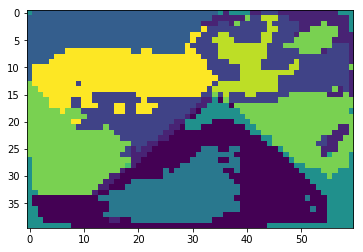

rbf entropy
0.1616153401897867
0.15196138654954042
0.1540015716599095
0.15611110315962426
0.15962712754036879
0.16040190218753025
0.15639010604115222
0.1521662935886215
0.1582894605955821
0.15834776609232062
0.1593797437901567
0.15921957486931573
0.1391430682556711
0.16044888034060079
0.1489840554174693
0.156949382723474
0.1571570007892272
0.1460437839899334
0.1375617709328292
0.15315185950932378
0.14877380418833186
0.14786286865949327
0.16261159720312993
0.1617139885079656
0.15797155584893213
0.15272671596842302
0.1555626758367195
0.15136016176468856
0.1350832850813476
0.1426920113968827
0.15481334309069522
0.15526247099015567
0.15891312753865083
0.144784821747562
0.15564128595528204
0.15571505527199786
0.1470584105021171
0.1557860233146907
0.15873348956116998
0.16319871119692062
0.15090731875029847
nn entropy
0.1616153401897867
0.15196138654954042
0.1540015716599095
0.15611110315962426
0.15962712754036879
0.16040190218753025
0.15639010604115222
0.1521662935886215
0.1582894605955821
0

In [26]:
img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

def f(path, sub):
    images = os.listdir(dirc_train)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))
        f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(f)
print("rbf entropy")
f(dirc_normalized_rbf, '11_10')
print("nn entropy")
f(dirc_normalized_nn, '11_1')


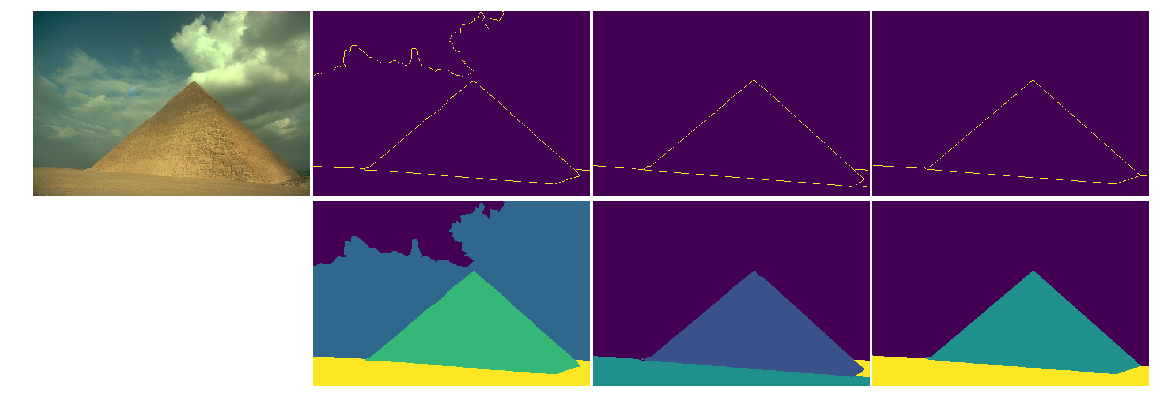

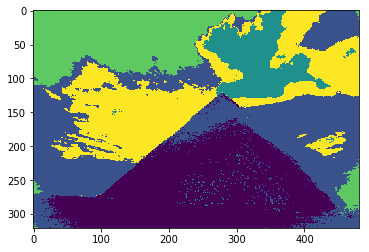

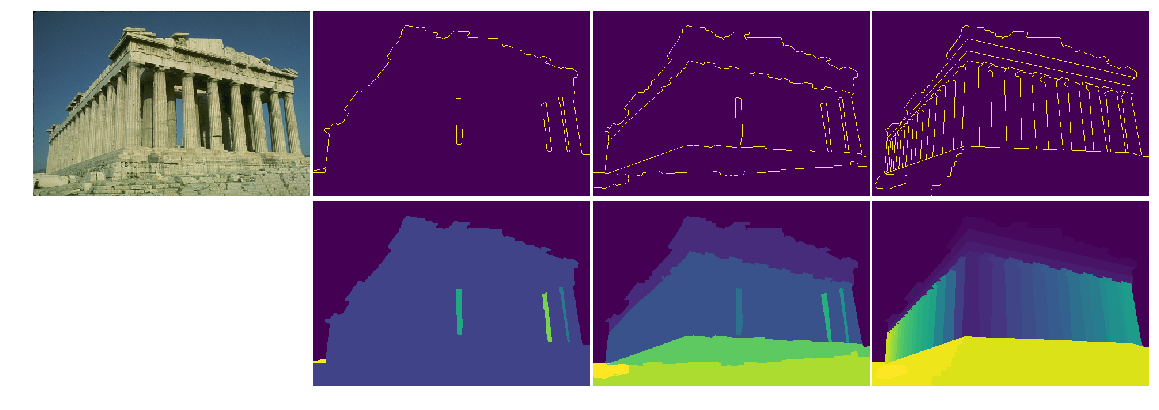

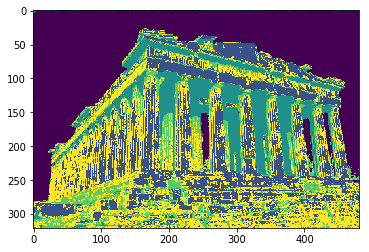

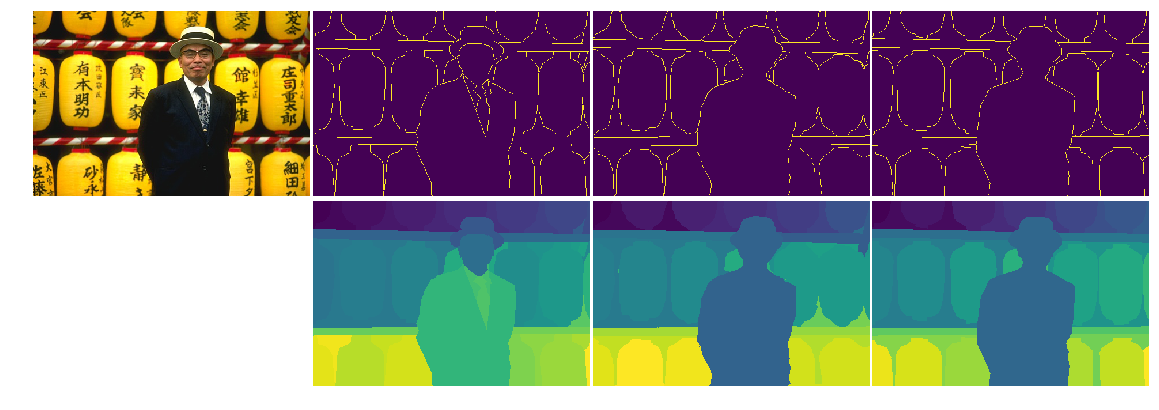

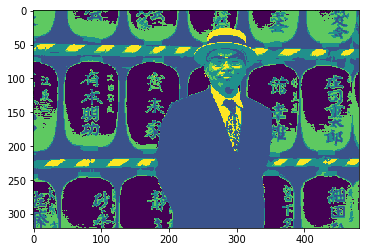

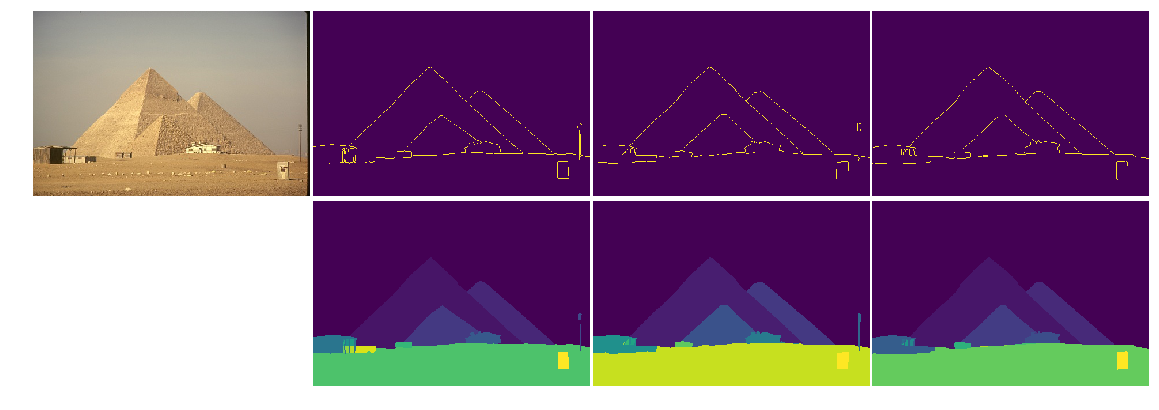

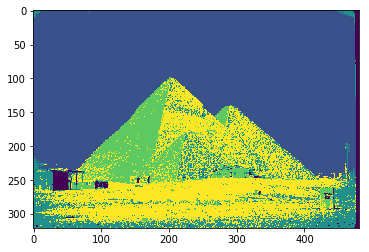

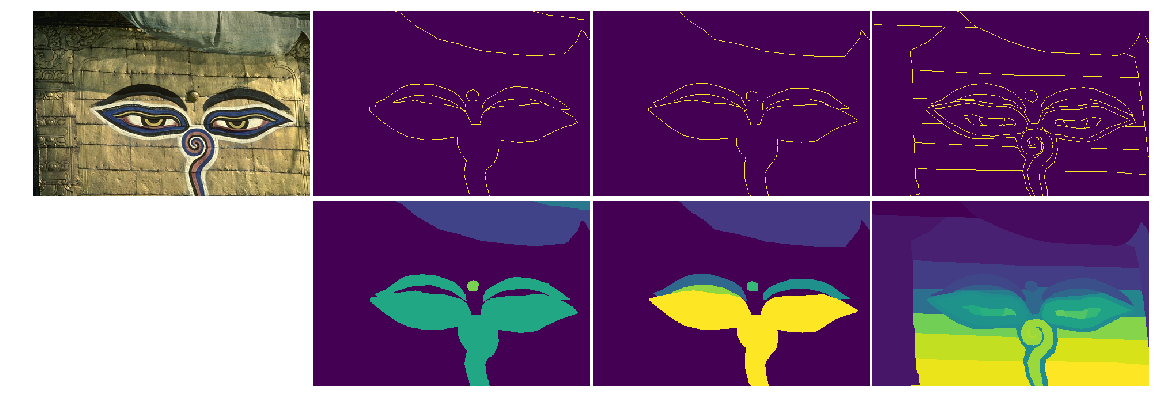

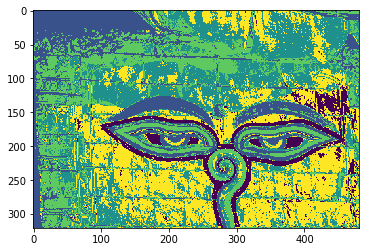

In [132]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

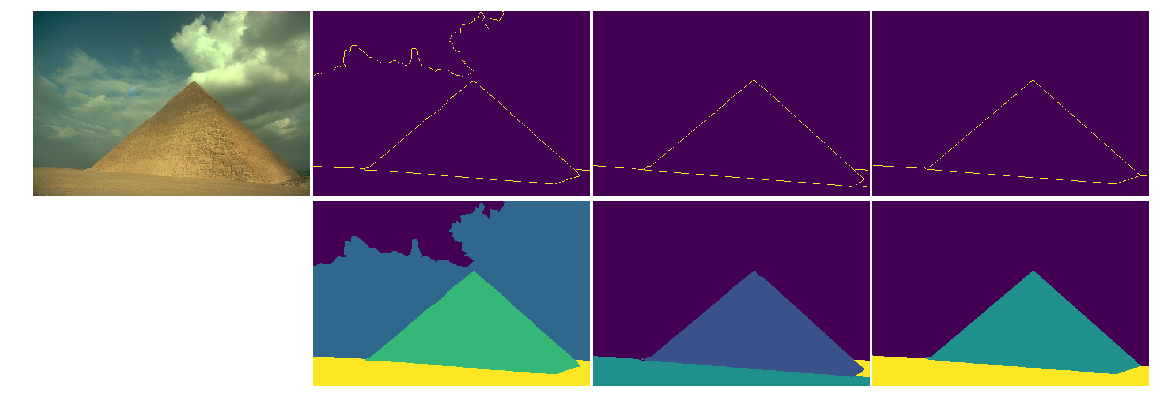

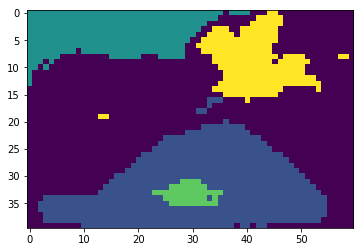

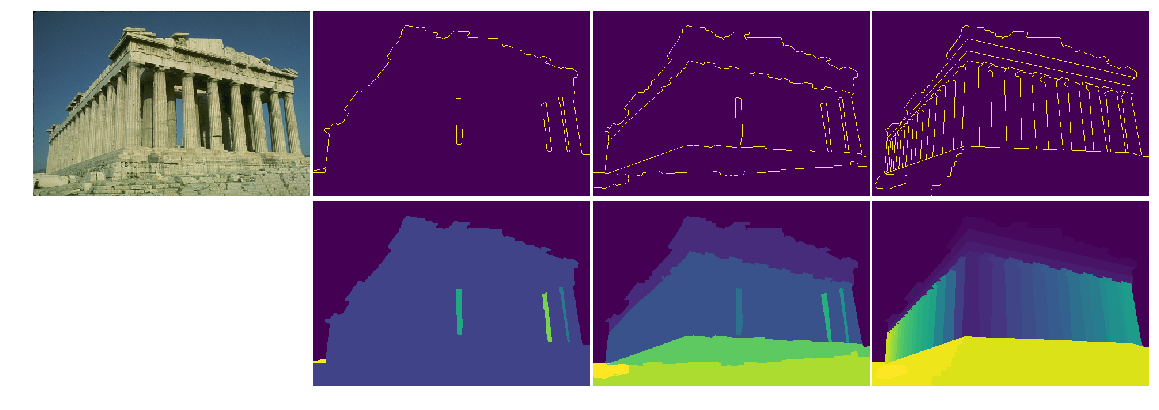

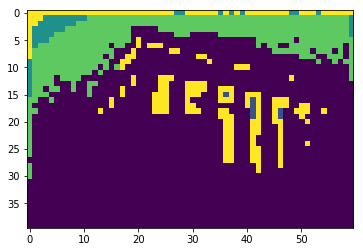

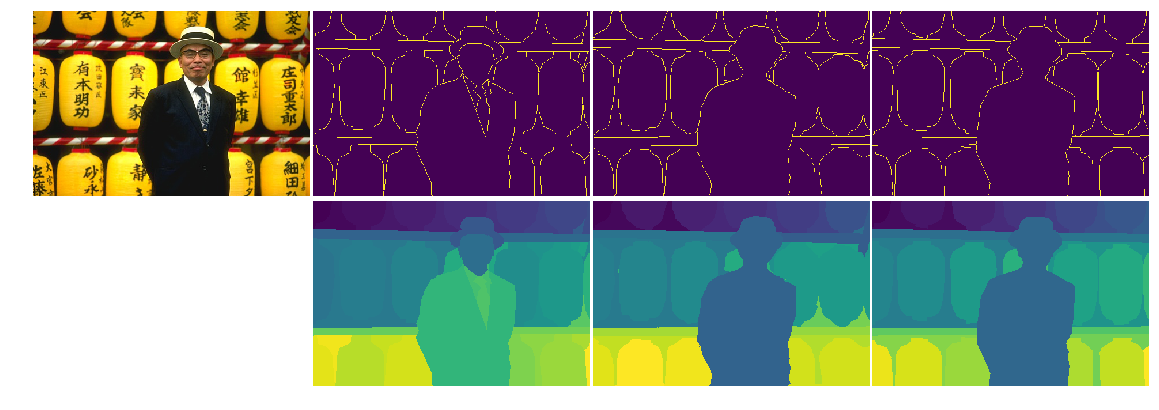

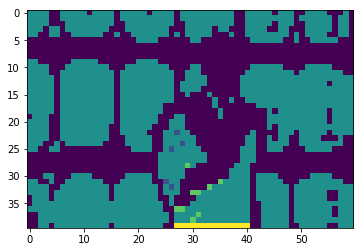

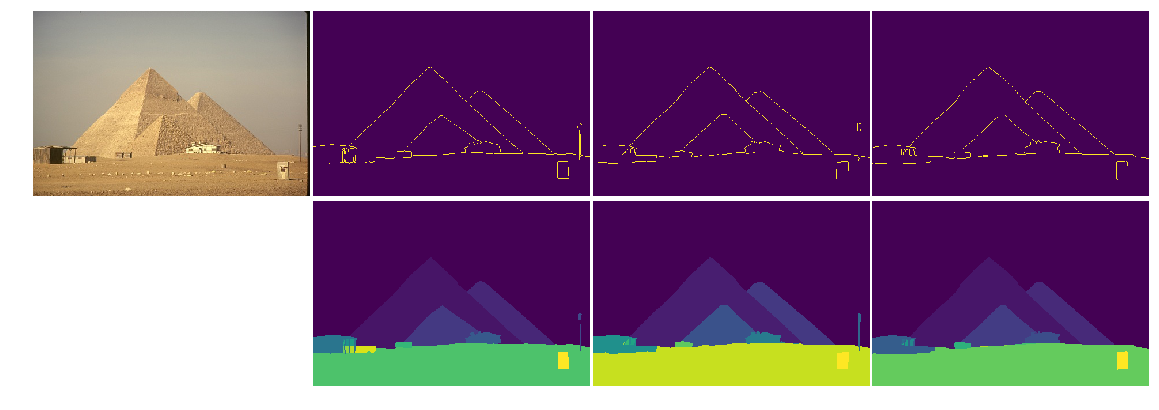

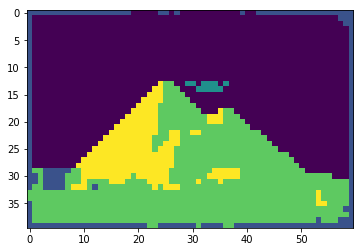

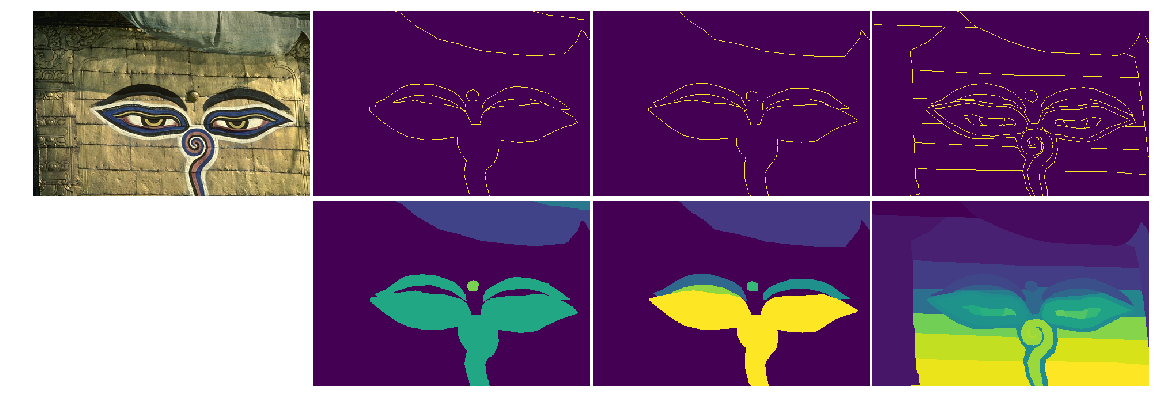

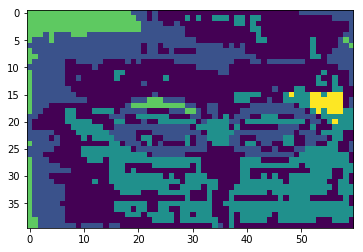

In [133]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

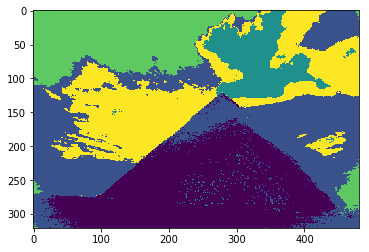

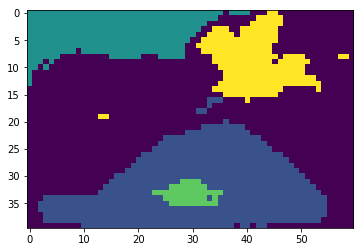

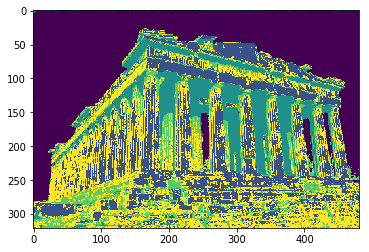

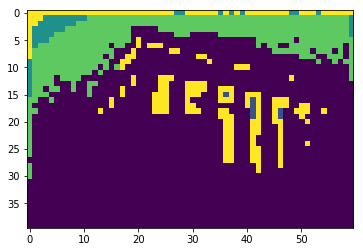

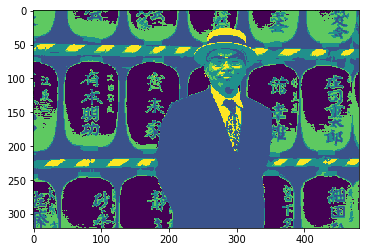

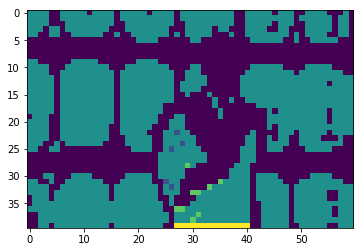

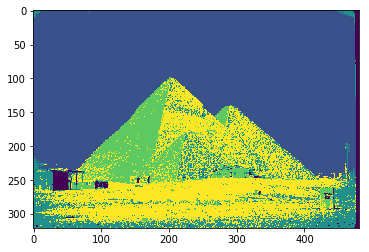

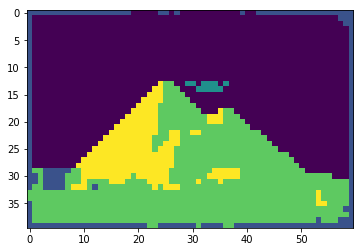

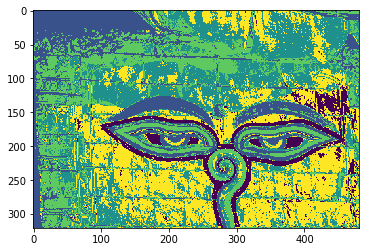

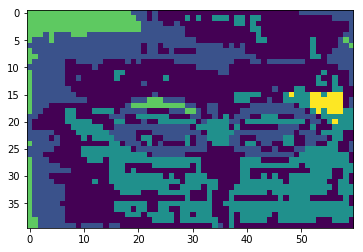

In [134]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    img1 = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    img2 = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    print('\n\n\n\n\n\n')